In [664]:
import numpy as np
import sys
import itertools

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

CONVERT = 1L << (2*np.arange(12).reshape((3,4))[:,:-1])
'''
         01 01 01 00            10 10 10 00
MASK01 = 01 01 01 00   MASK10 = 10 10 10 00
         01 01 01 00            10 10 10 00
'''
MASK01 = 1381653L #a board full of 01
MASK10 = MASK01 << 1 #a board full of 10
MASK11 = MASK01 | MASK10

class Board(object):
    """The board object will be a 3x3 array of bitboards and a single mega-board bitboard.
    
    The bitboards will be such that the bit representing each location is given by the map
    
    00 02 04
    08 10 12
    16 18 20
    
    Each bit represents one of the player's pieces occupying a cell.
    00 -> empty cell
    01 -> player 1
    10 -> player 2
    11 -> wild card
    
    """
    
    def __init__(self,board = 'None',active_board = (1,1),big_board = 'None',player = 1):
        self.player = 0L if player == 1 else 1L
        self.log = []
        self.alog = [active_board]
        self.over = False
        self.result = 0L
        
        self.active_board = active_board
        
        if board == 'None':
            self.board = np.zeros((3,3)).astype(long)
        else:
            self.board = np.zeros((3,3)).astype(long)
            board = np.copy(board)
            for i in range(3):
                for j in range(3):
                    p1 = (board[3*i:3*i+3,3*j:3*j+3]==1)
                    p2 = (board[3*i:3*i+3,3*j:3*j+3]== - 1)
                    self.board[i,j] = np.sum( p1 * CONVERT + p2 * (CONVERT << 1))
                    

        if big_board == 'None':
            self.big_board = 0L
        else:
            self.big_board = np.sum(big_board.astype(long) * CONVERT)
            
        
            

    def update_move(self,move,safe = False):
        if safe:
            assert(move in self.legal_moves())
        active_board = (move[0]/3,move[1]/3)
        index = (move[0]%3)*8 + (move[1]%3)*2 #gives the bit-location for the move        
        self.board[active_board] ^= 1L << index << self.player
        active_index = (active_board[0]%3)*8 + (active_board[1]%3)*2
        if not (self.big_board >>active_index & 3): #if the board isn't over yet, check to see if it is   
            winner = check_board_win(self.board[active_board])
        else:
            winner = 0
        if winner:
            self.big_board ^= winner << active_index 
            result = check_board_win(self.big_board)
            if result:
                if result==1:
                    self.result = 1
                elif result == 2:
                    self.result = -1
                elif result == 3:
                    self.result = -2
                else:
                    sys.exit("result not 0 1 -1 or 2")
                self.over = True        
        
        self.player ^=1
        self.active_board = (move[0]%3,move[1]%3)
        self.log.append(move)
        self.alog.append(self.active_board)
        return None
    

        
    def erase_move(self):
        move = self.log.pop()
        active_board = (move[0]/3,move[1]/3)
        index = (move[0]%3)*8 + (move[1]%3)*2 #gives the bit-location for the move    
        self.alog.pop()
        
        self.player ^=1
        
        self.board[active_board] ^= 1L << index << self.player
        
        winner = check_board_win(self.board[active_board])
        if not winner:
            active_index = (active_board[0]%3)*8 + (active_board[1]%3)*2                        
            self.big_board &= ~(3 << active_index) # turn off 11 at location active_index                
                
        

        self.active_board = self.alog[-1]
        self.over = False
        self.result = 0
            
        return None
    
#     def is_legal(self,move):
#         active_board = self.board[self.active_board]
        
    def legal_moves(self):
        if self.over:
            return []
        
        if self.log == []:
            #returns all empty cells
            return [(i,j) for i,j in itertools.product(range(9),range(9)) 
                    if not (self.board[i/3,j/3]>>(8*(i%3)+2*(j%3)) & 3)]
            
        
        active_board = self.board[self.active_board] #need to check if the active board has space
        mp = moves_played(active_board)
        if mp<8:#board has space, don't return a move to previous board
            last_active = (self.log[-1][0]/3,self.log[-1][1]/3)
            
            moves = [(self.active_board[0]*3+i,self.active_board[1]*3+j) 
                     for i,j in itertools.product(range(3),range(3)) if not (active_board>>(8*i+2*j) & 3) and
                     (i,j) != last_active]#checks if cell is empty
            
              
        elif mp==8:
            for i,j in itertools.product(range(3),range(3)):
                if not (active_board>>(8*i+2*j) & 3):
                    move = (self.active_board[0]*3+i,self.active_board[1]*3+j)
                    break #saves time
            moves = [move]
            
            
        elif mp ==9:
            last_active = (self.log[-1][0]/3,self.log[-1][1]/3)
            moves = []
            illegal = []
            for i,j in itertools.product(range(9),range(9)):
                if not (self.board[i/3,j/3] >> (8*(i%3) + 2*(j%3))&3):#cell is empty
                    if (i%3,j%3) == last_active:
                        illegal.append((i,j))
                    else:
                        moves.append((i,j))
            if len(moves)==0:
                moves = illegal            
            
        else:
            print active_board
            print 'moves played : ',mp
            sys.exit('board has more than 9 moves played???')
        return moves
        
        

    def key(self):
        board = self.board.reshape(-1)
#         return tuple(self.board.reshape(-1))
    
    def print_board(self):
        #returns a board and big_board arrays
        def recon(bitboard):
            answer = np.zeros((3,3))
            dummy = bitboard
            for i in range(3):
                for j in range(3):
                    val = dummy%4
                    if val == 1 or val == 0:
                        answer[i,j] = val
                    elif val == 2:
                        answer[i,j] = -1
                    elif val == 3:
                        answer[i,j] = 2
                    else:
                        sys.exit('impossible')
                    dummy /= 4
                dummy /=4
            return answer
        col_stacks = (np.concatenate((recon(self.board[0,0]),recon(self.board[1,0]),recon(self.board[2,0]))),
                      np.concatenate((recon(self.board[0,1]),recon(self.board[1,1]),recon(self.board[2,1]))),
                      np.concatenate((recon(self.board[0,2]),recon(self.board[1,2]),recon(self.board[2,2]))))
        board = np.concatenate(col_stacks,axis=1)
        return board , recon(self.big_board)
        
        
    
def moves_played(board):
    mp = 0
    for i in xrange(12):
        if board & 3:
            mp+=1
        board >>=2
    return mp
#     return bin(board).count('1') #seems to be very fast but screws up when needing to look at '11's are possibilities
    
def check_board_win(board):
    winner = 0L
    '''
    legend
     3: both players win! tie
     2: player 2 wins
     1: player 1 wins
     0: game ongoing!
    '''


#     check player 1 win
    board01 = board & MASK01
    if ((board01 & board01<<2 & board01<<4) or  #horizontal check
        (board01 & board01<<6 & board01<<12) or #diagonal / check
        (board01 & board01<<8 & board01<<16) or #vertical check
        (board01 & board01<<10& board01<<20)):  #diagonal \ check

        winner ^=1L

    #check player 2 win
    board10 = board & MASK10
    if ((board10 & board10<<2 & board10<<4) or  #horizontal check
        (board10 & board10<<6 & board10<<12) or #diagonal / check
        (board10 & board10<<8 & board10<<16) or #vertical check
        (board10 & board10<<10& board10<<20)):  #diagonal \ check

        winner ^=2L

    if winner == 0 and moves_played(board)==9:
        winner = 3L
        
        
    return winner

def fancy_board(game):
    board,big_board = game.print_board()
    print_board = np.copy(board).astype(float)
    for x,y in itertools.product(range(9),range(9)):
        if big_board[x/3,y/3] != 0:
            if print_board[x,y] == 0:
                print_board[x,y] = 0.5
            else:
                print_board[x,y] = 0
            print_board[x,y] += big_board[x/3,y/3]
        if (x,y) in game.legal_moves():
            print_board[x,y] = -2






In [603]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

def recon(bitboard):
    answer = np.zeros((3,3))
    dummy = bitboard
    for i in range(3):
        for j in range(3):
            val = dummy%4
            if val == 1 or val == 0:
                answer[i,j] = val
            elif val == 2:
                answer[i,j] = -1
            elif val == 3:
                answer[i,j] = 2
            else:
                sys.exit('impossible')
            dummy /= 4
        dummy /=4
    return answer
def fancy_board(game):
    board,big_board = game.print_board()
    print_board = np.copy(board).astype(float)
    for x,y in itertools.product(range(9),range(9)):
        if big_board[x/3,y/3] != 0:
            if print_board[x,y] == 0:
                print_board[x,y] = 0.5
            else:
                print_board[x,y] = 0
            print_board[x,y] += big_board[x/3,y/3]
        if (x,y) in game.legal_moves():
            print_board[x,y] = -2
        
#     print game.board
#     print game.big_board
#     print active_board
    
    plt.matshow(print_board,vmin = -2,vmax = 2)
    plt.plot([-0.5,8.5],[2.5,2.5],'k')
    plt.plot([-0.5,8.5],[5.5,5.5],'k')
    plt.plot([2.5,2.5],[-0.5,8.5],'k')
    plt.plot([5.5,5.5],[-0.5,8.5],'k')

[[ 1. -1. -1.]
 [ 0.  1. -1.]
 [ 1.  1. -1.]]
-1
[(8, 0), (7, 0), (4, 0), (3, 0), (1, 2), (4, 8), (5, 6), (6, 0), (1, 1), (4, 4), (5, 3), (7, 2), (3, 7), (0, 3), (1, 0), (4, 1), (3, 3), (2, 0), (6, 1), (1, 4), (5, 4), (8, 3), (8, 2), (7, 7), (4, 5), (3, 6), (0, 0), (0, 2), (2, 6), (8, 1), (6, 5), (0, 6), (0, 1), (2, 4), (6, 3), (2, 1), (6, 4), (2, 5), (6, 6), (6, 8), (2, 7), (7, 5), (5, 8), (7, 6), (3, 1), (1, 5), (5, 7), (7, 4), (3, 4), (0, 4), (1, 3), (4, 2), (3, 8), (2, 8), (8, 8), (6, 7), (0, 5), (1, 7), (5, 5), (8, 6)]
60
[(8, 0), (7, 0), (4, 0), (3, 0), (1, 2), (4, 8), (5, 6), (6, 0), (1, 1), (4, 4), (5, 3), (7, 2), (3, 7), (0, 3), (1, 0), (4, 1), (3, 3), (2, 0), (6, 1), (1, 4), (5, 4), (8, 3), (8, 2), (7, 7), (4, 5), (3, 6), (0, 0), (0, 2), (2, 6), (8, 1), (6, 5), (0, 6), (0, 1), (2, 4), (6, 3), (2, 1), (6, 4), (2, 5), (6, 6), (6, 8)]
40
[(8, 0), (7, 0), (4, 0), (3, 0), (1, 2), (4, 8), (5, 6), (6, 0), (1, 1), (4, 4), (5, 3), (7, 2), (3, 7), (0, 3), (1, 0), (4, 1), (3, 3), (2, 0)

C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


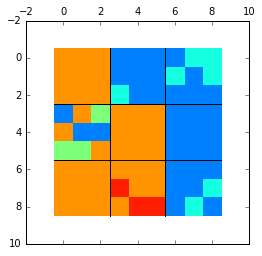

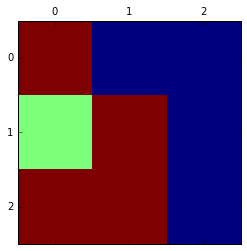

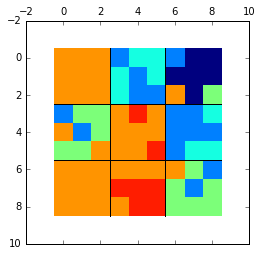

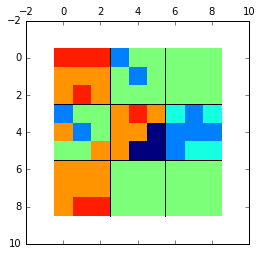

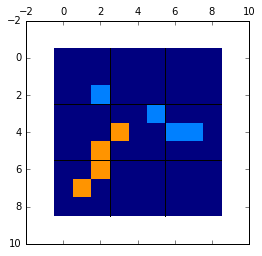

In [668]:
from IPython import display

board = np.zeros((9,9))
for x in [(7,1),(6,2),(5,2),(4,3)]:
    board[x]=1
for o in [(2,2),(3,5),(4,6),(4,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = (1,1)
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
# print board
# g_board,g_bboard = game.print_board()
# fancy_board(game)


moves = [(8,0),(7,0),(4,0),(3,0),(1,2),(4,8),(5,6),(6,0),(1,1),(4,4),(5,3),(7,2),(3,7),(0,3),(1,0),(4,1),(3,3)
        ,(2,0),(6,1),(1,4),(5,4),(8,3),(8,2),(7,7),(4,5),(3,6),(0,0),(0,2),(2,6),(8,1),(6,5),(0,6),(0,1),(2,4)
        ,(6,3),(2,1),(6,4),(2,5),(6,6),(6,8),(2,7),(7,5),(5,8),(7,6),(3,1),(1,5),(5,7),(7,4),(3,4),(0,4),(1,3)
        ,(4,2),(3,8),(2,8),(8,8),(6,7),(0,5),(1,7),(5,5),(8,6)]
for move in moves:
    game.update_move(move)
    fancy_board(game)
    
# print game.legal_moves()
print recon(game.big_board)
# print game.print_board()[0]
# print recon(game.big_board)
fancy_board(game)
plt.matshow(recon(game.big_board),vmax=1,vmin=-1)
print game.result

print game.log
print len(game.log)
for _ in range(20):
    game.erase_move()
print game.log
print len(game.log)
fancy_board(game)
for _ in range(20):
    game.erase_move()
print game.log
print len(game.log)
fancy_board(game)
for _ in range(20):
    game.erase_move()
print game.log
print len(game.log)
fancy_board(game)

In [583]:
bool(check_board_win(game.board[1,0]))

False

[(7, 0), (4, 1), (4, 4), (4, 5), (4, 8), (3, 7)]
65536
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0. -1. -1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]]


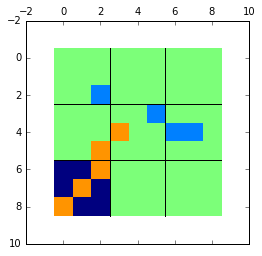

In [543]:
print log
# for move in log:
#     game.update_move(move)
moves = [(8,0)]
for move in moves:
    game.update_move(move)
print game.big_board
print game.print_board()[0]
print recon(game.big_board)
fancy_board(game)

In [536]:
game.big_board

0

In [151]:
def recon(bitboard):
    answer = np.zeros((3,3))
    dummy = bitboard
    for i in range(3):
        for j in range(3):
            answer[i,j] = dummy%4
            dummy /= 4
        dummy /=4
    return answer

In [406]:

import cProfile
def fun():
    for _ in range(10000):
        x = random.randint(0,2**16-1)
        moves = moves_played(x)
def conv():
    for _ in range(10000):
        x = random.randint(0,2**16-1)
        moves = bin(x).count('1')
cProfile.run('fun()')
cProfile.run('conv()')

         40004 function calls in 0.156 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.070    0.000    0.070    0.000 <ipython-input-405-319794ff0087>:153(moves_played)
        1    0.021    0.021    0.156    0.156 <ipython-input-406-7b17cbb43d18>:3(fun)
        1    0.000    0.000    0.156    0.156 <string>:1(<module>)
    10000    0.046    0.000    0.049    0.000 random.py:175(randrange)
    10000    0.015    0.000    0.064    0.000 random.py:238(randint)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
    10000    0.002    0.000    0.002    0.000 {method 'random' of '_random.Random' objects}
        1    0.000    0.000    0.000    0.000 {range}


         50004 function calls in 0.097 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.024    0.024    0.097    0.097 <ipython-input-406-7b

In [377]:
x = random.randint(0,2**16-1)
moves_played(x)

8

In [384]:
bin(MASK11).count('1')

18

In [395]:
game.key()

(2097152, 0, 0, 1048576, 288, 2560, 1040, 0, 0)

In [400]:
MASK11 >>=2

In [412]:
x = (np.array([[1]]),np.array([[2]]))
np.concatenate(x,axis=0)

array([[1],
       [2]])

In [673]:
import random
import time
from IPython import display

board = np.zeros((9,9))
for x in [(7,1),(6,2),(5,2),(4,3)]:
    board[x]=1
for o in [(2,2),(3,5),(4,6),(4,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = (1,1)
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
loglen = len(game.log)
for sims in range(5):
    while not game.over:

        move = random.choice(game.legal_moves())
        game.update_move(move)
        display.clear_output(wait = True)
        fancy_board(game)
        plt.show()    
        time.sleep(0.)
        if game.over:
            print game.result

    while len(game.log)>loglen:
        game.erase_move()
        display.clear_output(wait = True)
        fancy_board(game)
        plt.show()    
        time.sleep(0.)
        if game.over:
            print game.result


KeyboardInterrupt: 

In [676]:
(board == 1) + (board == -1)

array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False],
       [False, False, False, False, False,  True, False, False, False],
       [False, False, False,  True, False, False,  True,  True, False],
       [False, False,  True, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]], dtype=bool)